## Week 1: Crypto Sentiment Data Collection
### Project 1 - Crypto Sentiment Classifier

GOALS FOR THIS WEEK:
1. Collect 5,000+ crypto tweets
2. Get Bitcoin price data
3. Basic data exploration
4. Apply VADER sentiment (baseline)

#### Import and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import requests
import time
from pathlib import Path

In [2]:
# For sentiment analysis baseline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create output directories if they don't exist
Path('/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/data/raw').mkdir(parents=True, exist_ok=True)
Path('/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/data/processed').mkdir(parents=True, exist_ok=True)
Path('/Users/yangxiaotong/Documents/Projects/BC-Portfolio/crypto-sentiment-project/results').mkdir(parents=True, exist_ok=True)

print('✅ Set up complete!')

✅ Set up complete!


#### Collect Bitcoin price data

In [6]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 242.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 3.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.18.3-py3-none-any.whl size=139133 sha256=0645aeddeb7c17e10eef7f4d0e020b3daf1bf1100da1512e8f5c3d19d9d71c06
  Stored in directory: /Users/yangxiaotong/Library/Caches/pip/wheels/3d/96/39/80c50cbf6bd446cdca9dac7d78a1a0d3a1f313859500529f8d
Successfully built peewee
  DEPRECATION: multitasking is being installed using the legacy 'setup

In [7]:
import yfinance as yf

def get_bitcoin_prices(days=30):
    """
    Fetch Bitcoin hourly price data using Yahoo Finance (yfinance).
    Always works worldwide, no API key, no region blocks.
    """

    print(f"📊 Fetching Bitcoin prices for last {days} days using Yahoo Finance...")

    btc = yf.Ticker("BTC-USD")

    try:
        # interval = '1h' for hourly data
        df = btc.history(period=f"{days}d", interval="1h")

        if df.empty:
            raise ValueError("Empty data returned.")

        df = df.reset_index()
        df = df[["Datetime", "Close"]]
        df.columns = ["timestamp", "price"]

        print(f"✅ Collected {len(df)} hourly price points")
        return df

    except Exception as e:
        print(f"❌ Error fetching prices: {e}")
        return None


# Run it!
btc_prices = get_bitcoin_prices(days=30)

if btc_prices is not None:
    print("\nFirst rows:")
    print(btc_prices.head())

    print("\nSummary stats:")
    print(btc_prices["price"].describe())

    btc_prices.to_csv("../data/raw/btc_prices.csv", index=False)
    print("💾 Saved to data/raw/btc_prices.csv")


📊 Fetching Bitcoin prices for last 30 days using Yahoo Finance...
✅ Collected 599 hourly price points

First rows:
                  timestamp          price
0 2025-10-30 00:00:00+00:00  110551.328125
1 2025-10-30 01:00:00+00:00  110631.609375
2 2025-10-30 02:00:00+00:00  110958.750000
3 2025-10-30 03:00:00+00:00  110646.218750
4 2025-10-30 04:00:00+00:00  108786.546875

Summary stats:
count       599.000000
mean      99134.730306
std        8353.440675
min       82228.773438
25%       91391.003906
50%      101850.125000
75%      105540.781250
max      111356.843750
Name: price, dtype: float64
💾 Saved to data/raw/btc_prices.csv


#### Visualize price data

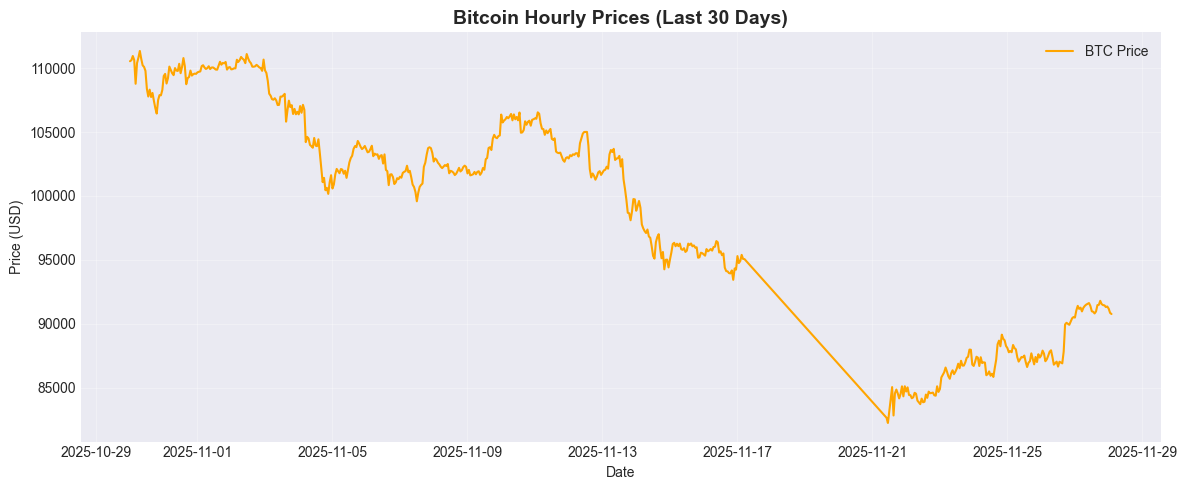

💾 Saved plot to results/btc_prices_plot.png


In [8]:
if btc_prices is not None:
    plt.figure(figsize=(12, 5))
    plt.plot(btc_prices['timestamp'], btc_prices['price'], label='BTC Price', color='orange')
    plt.title('Bitcoin Hourly Prices (Last 30 Days)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('../results/btc_prices_plot.png')
    plt.show()
    print("💾 Saved plot to results/btc_prices_plot.png")

#### Collect Twitter data using snscrape

In [11]:
"""
def collect_crypto_tweets_simple(keywords, max_tweets=1000, days_back=7):
    
    import snscrape.modules.twitter as sntwitter
    
    print(f"🐦 Collecting tweets about: {keywords}")
    print(f"   Max tweets: {max_tweets}, Days back: {days_back}")
    
    tweets_list = []

    # Build search query
    query = f"({' OR '.join(keywords)}) lang:en"
    since_date = (datetime.now() - timedelta(days=days_back)).strftime('%Y-%m-%d')
    until_date = datetime.now().strftime('%Y-%m-%d')
    
    query_full = f"{query} since:{since_date} until:{until_date}"
    
    print(f"   Search query: {query_full}")
    print("   Collecting... (this may take a few minutes)")
    
    try:
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query_full).get_items()):
            if i >= max_tweets:
                break
            
            tweets_list.append({
                'timestamp': tweet.date,
                'text': tweet.rawContent,
                'username': tweet.user.username,
                'likes': tweet.likeCount,
                'retweets': tweet.retweetCount,
                'replies': tweet.replyCount,
                'url': tweet.url
            })

            if (i + 1) % 100 == 0:
                print(f"   Collected {i + 1} tweets...")
        
        df = pd.DataFrame(tweets_list)
        print(f"✅ Collected {len(df)} tweets")
        return df
    
    except Exception as e:
        print(f"❌ Error collecting tweets: {e}")
        print("   Note: snscrape can be unstable. You may need to try again.")
        return None

# Collect tweets - Start small to test!
crypto_keywords = ['#Bitcoin', '#BTC', '$BTC', '#Crypto']

tweets_df = collect_crypto_tweets_simple(
    keywords=crypto_keywords,
    max_tweets=500,  # Start with 500 to test
    days_back=7
)
"""

'\ndef collect_crypto_tweets_simple(keywords, max_tweets=1000, days_back=7):\n    \n    import snscrape.modules.twitter as sntwitter\n    \n    print(f"🐦 Collecting tweets about: {keywords}")\n    print(f"   Max tweets: {max_tweets}, Days back: {days_back}")\n    \n    tweets_list = []\n\n    # Build search query\n    query = f"({\' OR \'.join(keywords)}) lang:en"\n    since_date = (datetime.now() - timedelta(days=days_back)).strftime(\'%Y-%m-%d\')\n    until_date = datetime.now().strftime(\'%Y-%m-%d\')\n    \n    query_full = f"{query} since:{since_date} until:{until_date}"\n    \n    print(f"   Search query: {query_full}")\n    print("   Collecting... (this may take a few minutes)")\n    \n    try:\n        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query_full).get_items()):\n            if i >= max_tweets:\n                break\n            \n            tweets_list.append({\n                \'timestamp\': tweet.date,\n                \'text\': tweet.rawContent,\n    

#### Back up - Use sample data if scraping fails

In [13]:
# Create realistic sample tweets
sample_tweets = [
    "Bitcoin is pumping! 🚀 Just broke $95k! #BTC",
        "This crash is brutal, lost so much money on $BTC 😭",
        "Just DCA'd into Bitcoin again, staying calm #HODL",
        "Bitcoin looking bearish, might go lower #BTC",
        "Institutions buying BTC again, bullish signal! 📈",
        "Regulatory news causing FUD in crypto markets",
        "Bitcoin dominance increasing, alt season over?",
        "Thinking about taking profits on my $BTC position",
        "This is why Bitcoin is the future of money 💰",
        "Scam alert! Don't fall for fake Bitcoin giveaways",
] * 50  # Replicate to simulate more data

timestamps = [datetime.now() - timedelta(hours=i) for i in range(len(sample_tweets))]

tweets_df = pd.DataFrame({
    'timestamp': timestamps,
    'text': sample_tweets,
    'username': ['user' + str(i) for i in range(len(sample_tweets))],
    'likes': np.random.randint(0, 1000, size=len(sample_tweets)),
    'retweets': np.random.randint(0, 500, size=len(sample_tweets)),
    'replies': np.random.randint(0, 300, size=len(sample_tweets)),
})

print(f"✅ Created {len(tweets_df)} sample tweets for learning")

✅ Created 500 sample tweets for learning


#### Explore the Tweet data

In [14]:
if tweets_df is not None:
    print("\n📊 TWEET DATA OVERVIEW")
    print("=" * 50)
    print(f"Total tweets: {len(tweets_df)}")
    print(f"Date range: {tweets_df['timestamp'].min()} to {tweets_df['timestamp'].max()}")
    print(f"\nFirst few tweets:")
    print(tweets_df[['timestamp', 'text', 'likes']].head())
    
    # Save raw tweets
    tweets_df.to_csv('../data/raw/crypto_tweets_raw.csv', index=False)
    print("\n💾 Saved to data/raw/crypto_tweets_raw.csv")


📊 TWEET DATA OVERVIEW
Total tweets: 500
Date range: 2025-11-07 08:55:20.698423 to 2025-11-28 03:55:20.697309

First few tweets:
                   timestamp  \
0 2025-11-28 03:55:20.697309   
1 2025-11-28 02:55:20.697925   
2 2025-11-28 01:55:20.697927   
3 2025-11-28 00:55:20.697928   
4 2025-11-27 23:55:20.697930   

                                                text  likes  
0        Bitcoin is pumping! 🚀 Just broke $95k! #BTC    411  
1  This crash is brutal, lost so much money on $B...    184  
2  Just DCA'd into Bitcoin again, staying calm #HODL    637  
3       Bitcoin looking bearish, might go lower #BTC    996  
4   Institutions buying BTC again, bullish signal! 📈    460  

💾 Saved to data/raw/crypto_tweets_raw.csv


#### Basic text preprocessing

In [ ]:
def clean_tweet_text(text):
    """
    Basic tweet text cleaning: remove URLs, mentions, hashtags.
    Keep hashtags for now because they're meaningful in crypto context. Only remove the hashtag symbol
    """
    import re
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)         # Remove hashtag symbol only
    text = ' '.join(text.split())        # Remove extra whitespace
    return text.strip()

if tweets_df is not None:
    tweets_df['text_cleaned'] = tweets_df['text'].apply(clean_tweet_text)
    print("\n🧹 CLEANED TEXT EXAMPLES:")
    print("=" * 50)
    for i in range(3):
        print(f"\nOriginal: {tweets_df.iloc[i]['text']}")
        print(f"Cleaned:  {tweets_df.iloc[i]['text_cleaned']}")


🧹 CLEANED TEXT EXAMPLES:

Original: Bitcoin is pumping! 🚀 Just broke $95k! #BTC
Cleaned:  Bitcoin is pumping! 🚀 Just broke $95k! BTC

Original: This crash is brutal, lost so much money on $BTC 😭
Cleaned:  This crash is brutal, lost so much money on $BTC 😭

Original: Just DCA'd into Bitcoin again, staying calm #HODL
Cleaned:  Just DCA'd into Bitcoin again, staying calm HODL


#### Apply VADER sentiment baseline

In [18]:
"""
VADER = Valence Aware Dictionary and sEntiment Reasoner
Good baseline for social media text, understands emojis and caps!
"""

def get_vader_sentiments(text):
    """
    Apply VADER sentiment analysis to tweets DataFrame.
    Returns compound score (-1 to +1)
    """
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    return scores

if tweets_df is not None:
    print("\n🎭 APPLYING VADER SENTIMENT ANALYSIS")
    print("=" * 50)

    analyzer = SentimentIntensityAnalyzer()

    # apply to all tweets
    vader_scores = tweets_df['text_cleaned'].apply(get_vader_sentiments)

    # Extract scores
    tweets_df['vader_neg'] = vader_scores.apply(lambda x: x['neg'])
    tweets_df['vader_neu'] = vader_scores.apply(lambda x: x['neu'])
    tweets_df['vader_pos'] = vader_scores.apply(lambda x: x['pos'])
    tweets_df['vader_compound'] = vader_scores.apply(lambda x: x['compound'])
    
    # Create sentiment label
    def sentiment_label(compound):
        if compound >= 0.05:
            return 'positive'
        elif compound <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    
    tweets_df['sentiment'] = tweets_df['vader_compound'].apply(sentiment_label)
    
    print("\n📊 SENTIMENT DISTRIBUTION:")
    print(tweets_df['sentiment'].value_counts())
    
    print("\n📝 EXAMPLE SENTIMENTS:")
    print("=" * 50)

    # Show examples from each category
    for sentiment_type in ['positive', 'negative', 'neutral']:
        example = tweets_df[tweets_df['sentiment'] == sentiment_type].iloc[0]
        print(f"\n{sentiment_type.upper()}: {example['text_cleaned']}")
        print(f"  Score: {example['vader_compound']:.3f}")


🎭 APPLYING VADER SENTIMENT ANALYSIS

📊 SENTIMENT DISTRIBUTION:
sentiment
negative    200
positive    200
neutral     100
Name: count, dtype: int64

📝 EXAMPLE SENTIMENTS:

POSITIVE: Just DCA'd into Bitcoin again, staying calm HODL
  Score: 0.318

NEGATIVE: Bitcoin is pumping! 🚀 Just broke $95k! BTC
  Score: -0.524

NEUTRAL: Institutions buying BTC again, bullish signal! 📈
  Score: 0.000


#### Visualize sentiment distribution

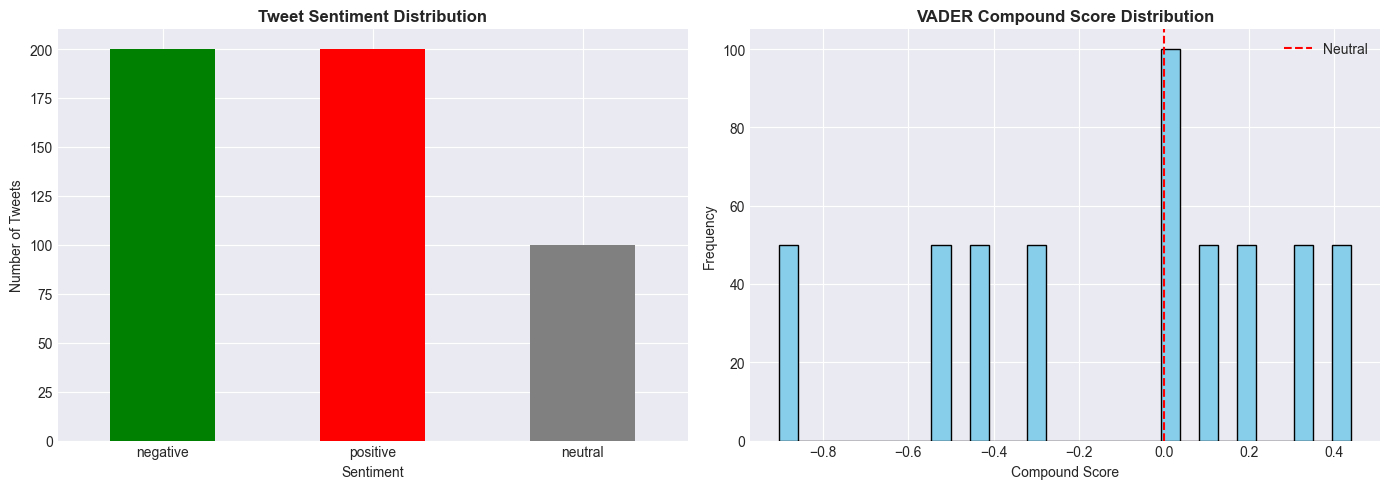


✅ Saved to results/sentiment_distribution.png


In [19]:
if tweets_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sentiment counts
    tweets_df['sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red', 'gray'])
    axes[0].set_title('Tweet Sentiment Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Number of Tweets')
    axes[0].tick_params(axis='x', rotation=0)

    # Compound score distribution
    axes[1].hist(tweets_df['vader_compound'], bins=30, color='skyblue', edgecolor='black')
    axes[1].set_title('VADER Compound Score Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Compound Score')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(x=0, color='red', linestyle='--', label='Neutral')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('../results/sentiment_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✅ Saved to results/sentiment_distribution.png")


#### Save processed data

In [20]:
if tweets_df is not None:
    # Save processed tweets with sentiment
    tweets_df.to_csv('../data/processed/tweets_with_sentiment.csv', index=False)
    print("\n💾 Saved processed data to data/processed/tweets_with_sentiment.csv")
    
    # Create a summary report
    summary = {
        'collection_date': datetime.now().isoformat(),
        'total_tweets': len(tweets_df),
        'date_range': {
            'start': tweets_df['timestamp'].min().isoformat(),
            'end': tweets_df['timestamp'].max().isoformat()
        },
        'sentiment_distribution': tweets_df['sentiment'].value_counts().to_dict(),
        'avg_sentiment_score': float(tweets_df['vader_compound'].mean()),
        'keywords_used': crypto_keywords
    }
    
    with open('../data/processed/collection_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("💾 Saved summary to data/processed/collection_summary.json")


💾 Saved processed data to data/processed/tweets_with_sentiment.csv
💾 Saved summary to data/processed/collection_summary.json


#### Week 1 summary and next steps

In [22]:
print("\n" + "=" * 70)
print("🎉 WEEK 1 COMPLETE! HERE'S WHAT WE DID:")
print("=" * 70)

#if btc_prices is not None:
#    print(f"✅ Collected {len(btc_prices)} Bitcoin price points")

if tweets_df is not None:
    print(f"✅ Collected {len(tweets_df)} crypto tweets")
    print(f"✅ Applied VADER sentiment analysis")
    print(f"✅ Created baseline sentiment labels")
    print(f"✅ Generated visualizations")

print("\n📝 NEXT STEPS FOR WEEK 2:")
print("1. Manually review 200 tweets to understand data quality")
print("2. Collect more data (aim for 5,000+ tweets)")
print("3. Start building custom sentiment model")
print("4. Correlate sentiment with price movements")

print("\n💡 HOMEWORK:")
print("1. Look at the saved CSV files in data/processed/")
print("2. Open tweets_with_sentiment.csv and review the sentiment labels")
print("3. Are they accurate? Make notes on what VADER gets wrong")
print("4. Think about crypto-specific words: 'moon', 'rekt', 'HODL', etc.")

print("\n" + "=" * 70)


🎉 WEEK 1 COMPLETE! HERE'S WHAT WE DID:
✅ Collected 500 crypto tweets
✅ Applied VADER sentiment analysis
✅ Created baseline sentiment labels
✅ Generated visualizations

📝 NEXT STEPS FOR WEEK 2:
1. Manually review 200 tweets to understand data quality
2. Collect more data (aim for 5,000+ tweets)
3. Start building custom sentiment model
4. Correlate sentiment with price movements

💡 HOMEWORK:
1. Look at the saved CSV files in data/processed/
2. Open tweets_with_sentiment.csv and review the sentiment labels
3. Are they accurate? Make notes on what VADER gets wrong
4. Think about crypto-specific words: 'moon', 'rekt', 'HODL', etc.

